# Variance Comparisons

The following codes generate the figures shown in my lab seminar presentation.

In [266]:
library(dplyr)
library(rstan)
library(ggplot2)
library(gridExtra)
library(xtable)

options(repr.plot.width = 10, repr.plot.height = 7)
group.colors <- c("JS+" = "#e91010", "Naive" = "#000000", "RB" ="#1c97e3", "RB+" = "#1cbd47")

source("bbvi_simplemix.R")

## Variance Comparisons Between Naive, Rao-Blackwellized, and James-Stein Estimators

We will be performing the estimation repeatedly, to get a controlled Monte Carlo sample of the inherent variances in the estimators being compared.

**Don't Run The Next Cell Unless Updating Results** Total expected run is at 3000 min.

In [295]:
niter <- 200
sampsize <- 200
mc_size <- 200

all_means <- -5:5
all_vars <- rep(3, times = length(all_means))

In [296]:
all.variances <- NULL
all.iterations <- list(10)

for(seed in 0:9){

    for(K in 2:10){
        
        d <- generate_mixture(sampsize, runif(K), means=all_means[1:K], vars=all_vars[1:K], seed = seed)$samp

        phi <- t(sapply(d, function(x){
            y <- runif(K)
            return(y/sum(y))
        }))

        m <- all_means[1:K] + 1
        iters <- list(niter)
        for(i in 1:niter){
            if(i %% 50 == 0) message(paste0("Mixture Components: ", K, "; Iteration: ", i, "/", niter))
            
            dat.nav <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="Naive")
            dat.rbl <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="RB")
            dat.jsp <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="JS+")
            dat.rbp <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="RB+")

            iters[[i]] <- rbind(
                cbind(method="Naive", iter=i, generate_bbvi(dat.nav)),
                cbind(method="RB", iter=i, generate_bbvi(dat.rbl)),
                cbind(method="JS+", iter=i, generate_bbvi(dat.jsp)),
                cbind(method="RB+", iter=i, generate_bbvi(dat.rbp))
            )
        }

        mse <- do.call('rbind',iters)
        if(K == 3) all.iterations[[seed+1]] <- mse # save this

        par.variances <- aggregate(mse[,4:ncol(mse)], by=list(method=mse$method, param=mse$param), var)
        for(method in c("Naive","RB","JS+","RB+")){
            this.method <- par.variances[par.variances$method == method,3:ncol(par.variances)]
            all.variances <- rbind(all.variances,
                data.frame(K=K, method=method,logVar=log(mean(as.matrix(this.method)))))
        }
    }

}

saveRDS(all.variances, "Outputs/all_variances.RDS")
saveRDS(mse, "Outputs/last_iteration.RDS")

Mixture Components: 2; Iteration: 50/200

Mixture Components: 2; Iteration: 100/200

Mixture Components: 2; Iteration: 150/200

Mixture Components: 2; Iteration: 200/200

Mixture Components: 3; Iteration: 50/200

Mixture Components: 3; Iteration: 100/200

Mixture Components: 3; Iteration: 150/200

Mixture Components: 3; Iteration: 200/200

Mixture Components: 4; Iteration: 50/200

Mixture Components: 4; Iteration: 100/200

Mixture Components: 4; Iteration: 150/200

Mixture Components: 4; Iteration: 200/200

Mixture Components: 5; Iteration: 50/200

Mixture Components: 5; Iteration: 100/200

Mixture Components: 5; Iteration: 150/200

Mixture Components: 5; Iteration: 200/200

Mixture Components: 6; Iteration: 50/200

Mixture Components: 6; Iteration: 100/200

Mixture Components: 6; Iteration: 150/200

Mixture Components: 6; Iteration: 200/200

Mixture Components: 7; Iteration: 50/200

Mixture Components: 7; Iteration: 100/200

Mixture Components: 7; Iteration: 150/200

Mixture Component

`summarise()` has grouped output by 'K'. You can override using the `.groups`
argument.


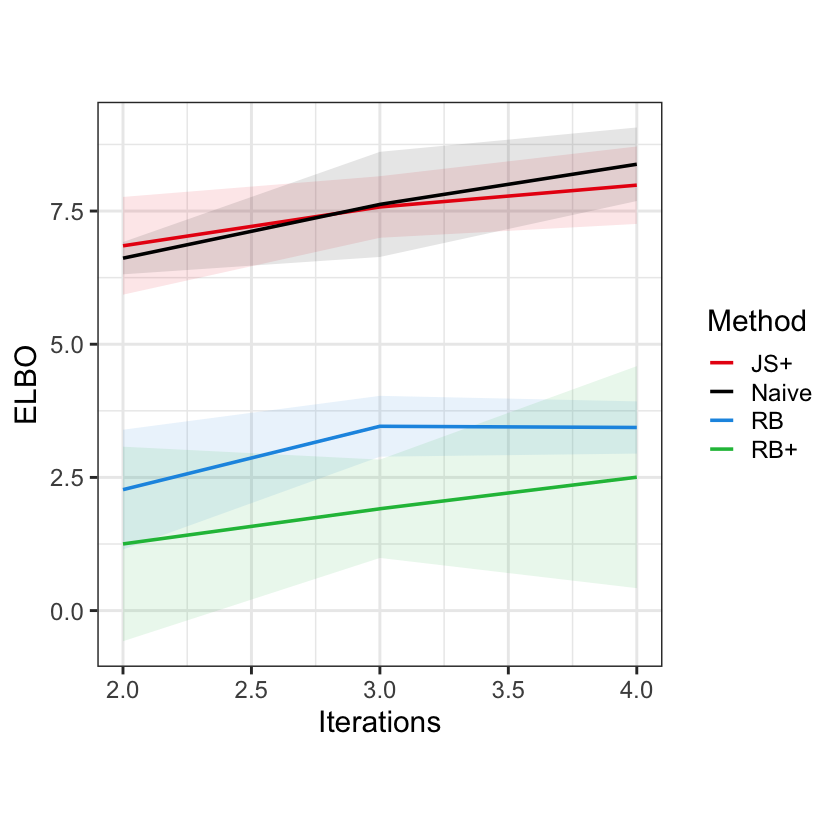

In [284]:
all.variances <- readRDS("Outputs/all_variances.RDS")

vars <- all.variances %>%
    group_by(K, method) %>%
    summarise(mean = mean(logVar), sd = sd(logVar))
    
    
p1 <- vars %>%
    ggplot(aes(K, mean, fill = method)) +
    geom_ribbon(data = vars, aes(ymin = mean - 2 * sd, ymax = mean + 2 * sd, group = method), alpha = 0.1) +
    geom_line(data = vars, aes(color = method), linewidth = 1) + 
    scale_fill_manual(values = group.colors, guide = "none") +
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Number of Clusters", y = "log(Variance)") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

options(repr.plot.width = 7, repr.plot.height = 7)
p1

## Using The BBVI Algorithm

This time we create the BBVI Algorithm In A Sample Dataset with K = 2 Components.

In [130]:
set.seed(923)
samp.dat <- generate_mixture(sampsize, runif(2), means=all_means[1:2], vars=all_vars[1:2])

In [297]:
seeds <- 0:9
all.elbo <- list(length(seeds))
all.params <- list(length(seeds))

for(i in seq_along(seeds)){
    samp.nav <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 500, learn_rate = rate_constant(1e-3), mc_size = 200, method = "Naive", verbose = TRUE, seed = seeds[i])
    samp.rbl <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 500, learn_rate = rate_constant(1e-3), mc_size = 200, method = "RB", verbose = TRUE, seed = seeds[i])
    samp.jsp <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 500, learn_rate = rate_constant(1e-3), mc_size = 200, method = "JS+", verbose = TRUE, seed = seeds[i])
    samp.rbp <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 500, learn_rate = rate_constant(1e-2), mc_size = 200, method = "RB+", verbose = TRUE, seed = seeds[i])

    all.elbo[[i]] <- bind_rows(
        samp.nav$elbo %>% mutate(method = "Naive"),
        samp.rbl$elbo %>% mutate(method = "RB"),
        samp.jsp$elbo %>% mutate(method = "JS+"),
        samp.rbp$elbo %>% mutate(method = "RB+")
    )

    all.params[[i]] <- bind_rows(
        samp.nav$paths %>% mutate(method = "Naive"),
        samp.rbl$paths %>% mutate(method = "RB"),
        samp.jsp$paths %>% mutate(method = "JS+"),
        samp.rbp$paths %>% mutate(method = "RB+")
    )
}

all.elbo <- do.call('rbind', all.elbo)
all.params <- do.call('rbind', all.params)

saveRDS(all.elbo, "Outputs/all_elbo.RDS")
saveRDS(all.params, "Outputs/all_params.RDS")

Doing Black Box Variational Inference With Method Naive



BBVI-Naive: Iteration 100 | Means at -5.02, -4.58 | Variances at 5.12, 0.65 | ELBO: -788.02

BBVI-Naive: Iteration 200 | Means at -4.75, -4.93 | Variances at 0.01, 2.35 | ELBO: -629.36

BBVI-Naive: Iteration 300 | Means at -4.47, -4.86 | Variances at 1.62, 0.97 | ELBO: -667.76

BBVI-Naive: Iteration 400 | Means at -4.86, -4.87 | Variances at 2.12, 0.56 | ELBO: -636.72

BBVI-Naive: Iteration 500 | Means at -4.93, -4.74 | Variances at 4.62, 0.09 | ELBO: -713.97

Doing Black Box Variational Inference With Method RB

BBVI-RB: Iteration 100 | Means at -4.58, -6.61 | Variances at 4.54, 7.08 | ELBO: -1174.86

BBVI-RB: Iteration 200 | Means at -4.49, -6.61 | Variances at 2.14, 7.08 | ELBO: -992.01

BBVI-RB: Iteration 300 | Means at -4.08, -6.61 | Variances at 0.01, 7.08 | ELBO: -789.8

BBVI-RB: Iteration 400 | Means at -4.46, -6.61 | Variances at 0.41, 7.08 | ELBO: -789.27

BBVI-RB: Iteration 500 | Means at -4.54, -6.61 | Variances at 3.21, 7.08 | ELBO: -1008.03

Doing Black Box Variational In

`summarise()` has grouped output by 'iter'. You can override using the
`.groups` argument.


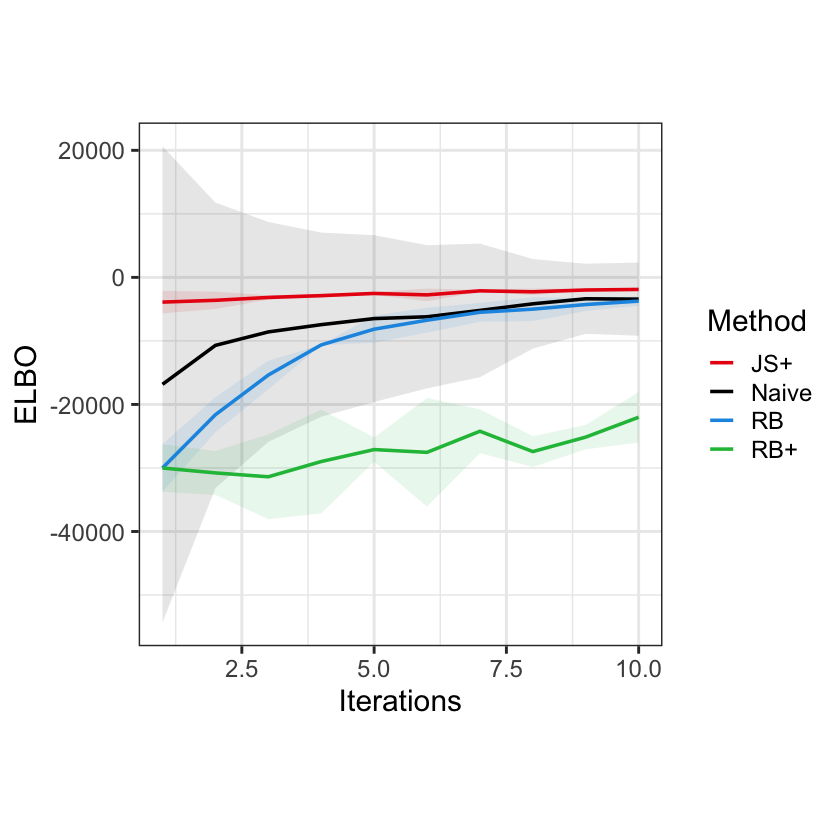

In [260]:
all.elbo <- readRDS("Outputs/all_elbo.RDS")

p2 <- all.elbo %>%
    group_by(iter, method) %>%
    summarise(mean = mean(elbo), sd = sd(elbo)) %>%
    ggplot(aes(iter, mean, fill = method)) +
    geom_ribbon(data = elbo.iters, aes(ymin = mean - 2 * sd, ymax = mean + 2 * sd, group = method), alpha = 0.1) +
    geom_line(data = elbo.iters, aes(color = method), linewidth = 1) + 
    scale_fill_manual(values = group.colors, guide = "none") +
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Iterations", y = "ELBO") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

options(repr.plot.width = 7, repr.plot.height = 7)
p2

`summarise()` has grouped output by 'iter'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'iter'. You can override using the
`.groups` argument.


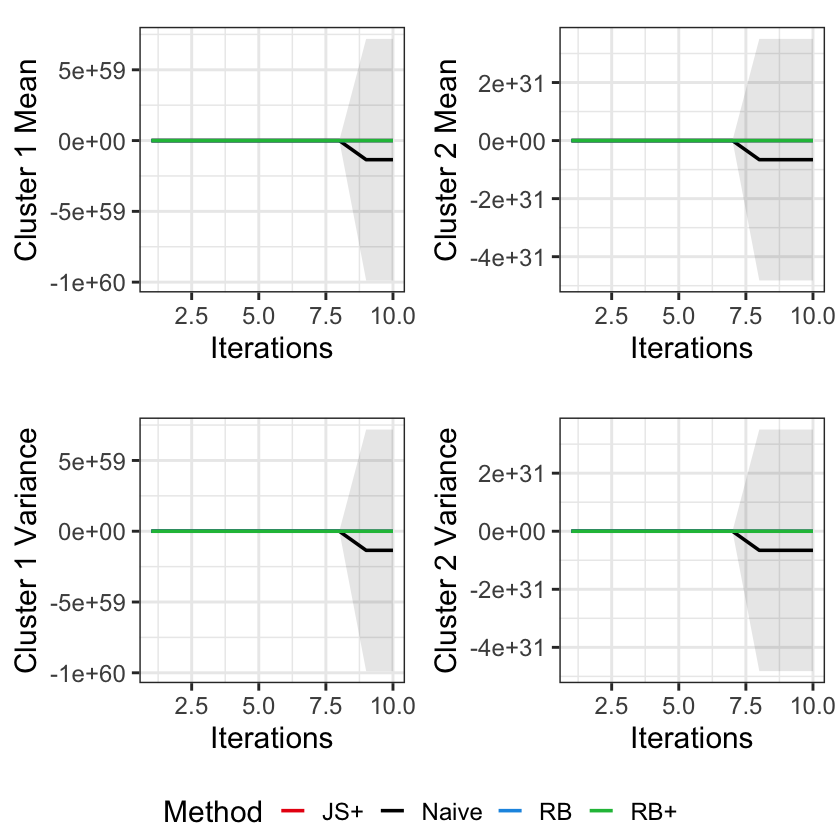

In [264]:
all.params <- readRDS("Outputs/all_params.RDS")

means <- all.params %>%
    filter(param == "m") %>%
    group_by(iter, method) %>%
    summarise(mean1 = mean(X1), mean2 = mean(X2), sd1 = sd(X1), sd2 = sd(X2)) 

vars <- all.params %>%
    filter(param == "ssq") %>%
    group_by(iter, method) %>%
    summarise(mean1 = mean(X1), mean2 = mean(X2), sd1 = sd(X1), sd2 = sd(X2)) 
    
p3 <- means %>%
    ggplot(aes(iter, mean1, fill = method)) +
    geom_ribbon(data = means, aes(ymin = mean1 - 2 * sd1, ymax = mean1 + 2 * sd1, group = method), alpha = 0.1) +
    geom_line(data = means, aes(color = method), linewidth = 1) + 
    scale_fill_manual(values = group.colors, guide = "none") +
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Iterations", y = "Cluster 1 Mean") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

p4 <- means %>%
    ggplot(aes(iter, mean2, fill = method)) +
    geom_ribbon(data = means, aes(ymin = mean2 - 2 * sd2, ymax = mean2 + 2 * sd2, group = method), alpha = 0.1) +
    geom_line(data = means, aes(color = method), linewidth = 1) + 
    scale_fill_manual(values = group.colors, guide = "none") +
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Iterations", y = "Cluster 2 Mean") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

p5 <- vars %>%
    ggplot(aes(iter, mean1, fill = method)) +
    geom_ribbon(data = means, aes(ymin = mean1 - 2 * sd1, ymax = mean1 + 2 * sd1, group = method), alpha = 0.1) +
    geom_line(data = means, aes(color = method), linewidth = 1) + 
    scale_fill_manual(values = group.colors, guide = "none") +
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Iterations", y = "Cluster 1 Variance") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

p6 <- vars %>%
    ggplot(aes(iter, mean2, fill = method)) +
    geom_ribbon(data = means, aes(ymin = mean2 - 2 * sd2, ymax = mean2 + 2 * sd2, group = method), alpha = 0.1) +
    geom_line(data = means, aes(color = method), linewidth = 1) + 
    scale_fill_manual(values = group.colors, guide = "none") +
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Iterations", y = "Cluster 2 Variance") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

ggarrange(p3, p4, p5, p6, common.legend = TRUE, legend="bottom")

## Constant, Reciprocal, AdaGrad, and RMSProp Learning Rates

This time we focus on BBVI-JS+ and compare its performance when performing estimation using a constant, reciprocal, agadrad, and rmsprop learning rates.

In [115]:
jsp.const <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_constant(1e-3), mc_size = 500, method = "JS+", verbose = TRUE)
jsp.recip <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_reciprocal(1e-3), mc_size = 500, method = "JS+", verbose = TRUE)
jsp.adagd <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_adagrad(1), mc_size = 500, method = "JS+", beta = NULL, verbose = TRUE)
jsp.rmspp <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_adagrad(1), mc_size = 500, method = "JS+", beta = 0.9, verbose = TRUE)

Doing Black Box Variational Inference With Method JS+

BBVI-JS+: Iteration 100 | Means at -4.73, -4.47 | Variances at 1.68, 0.65 | ELBO: -831.81

BBVI-JS+: Iteration 200 | Means at -4.75, -4.47 | Variances at 0.78, 0.64 | ELBO: -710.65

BBVI-JS+: Iteration 300 | Means at -4.75, -4.47 | Variances at 0.72, 0.63 | ELBO: -709.08

BBVI-JS+: Iteration 400 | Means at -4.75, -4.47 | Variances at 0.66, 0.61 | ELBO: -700.92

BBVI-JS+: Iteration 500 | Means at -4.75, -4.47 | Variances at 0.74, 0.59 | ELBO: -701.56

Doing Black Box Variational Inference With Method JS+

BBVI-JS+: Iteration 100 | Means at 0.91, 6.43 | Variances at 2.8, 4.64 | ELBO: -7791.53

BBVI-JS+: Iteration 200 | Means at 0.76, 6.04 | Variances at 2.79, 4.61 | ELBO: -7491.42

BBVI-JS+: Iteration 300 | Means at 0.66, 5.82 | Variances at 2.77, 4.6 | ELBO: -7038.24

BBVI-JS+: Iteration 400 | Means at 0.6, 5.67 | Variances at 2.76, 4.59 | ELBO: -6856.64

BBVI-JS+: Iteration 500 | Means at 0.56, 5.55 | Variances at 2.75, 4.58 | ELBO

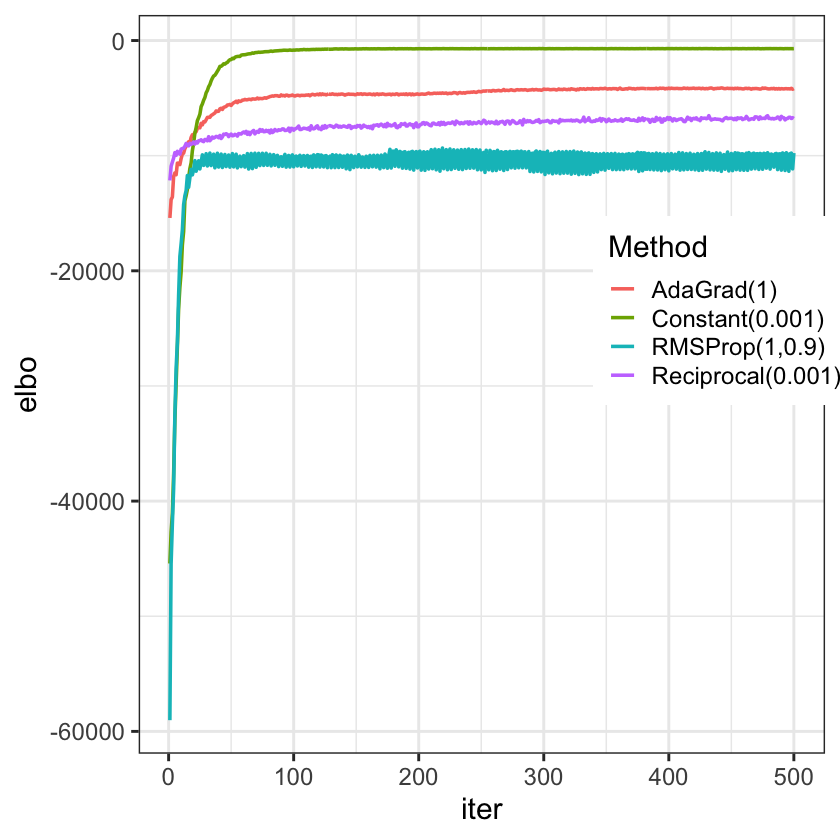

In [169]:
p6 <- bind_rows(
    jsp.const$elbo %>% mutate(method = "Constant(0.001)"),
    jsp.recip$elbo %>% mutate(method = "Reciprocal(0.001)"),
    jsp.adagd$elbo %>% mutate(method = "AdaGrad(1)"),
    jsp.rmspp$elbo %>% mutate(method = "RMSProp(1,0.9)")
) %>%
    ggplot(aes(x = iter, y = elbo, color = method)) + 
    geom_line(linewidth = 1) + 
    scale_y_continuous() +
    scale_color_discrete(name = "Method") +
    theme_bw(base_size=18) +
    theme(legend.position = c(0.85, 0.60))


options(repr.plot.width = 7, repr.plot.height = 7)
p6

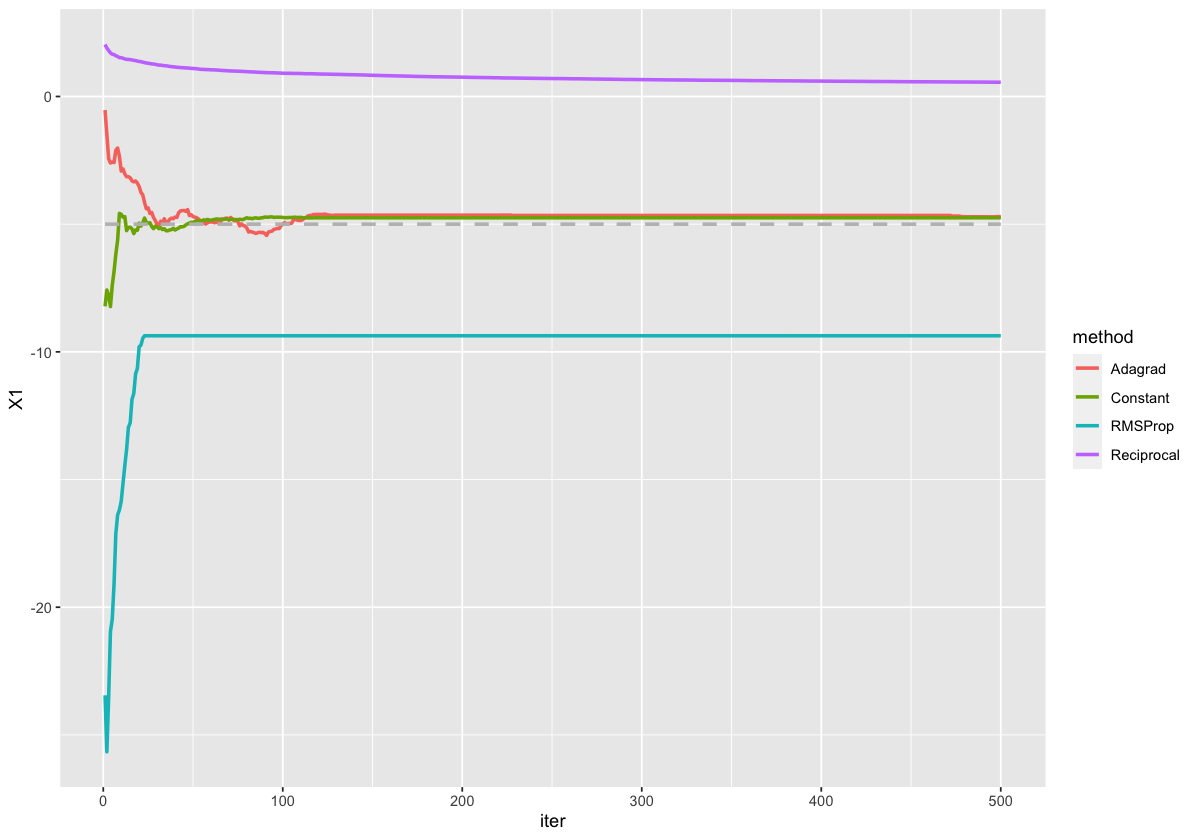

In [122]:
bind_rows(
    jsp.const$paths %>% filter(param == "m") %>% mutate(method = "Constant"),
    jsp.recip$paths %>% filter(param == "m") %>% mutate(method = "Reciprocal"),
    jsp.adagd$paths %>% filter(param == "m") %>% mutate(method = "Adagrad"),
    jsp.rmspp$paths %>% filter(param == "m") %>% mutate(method = "RMSProp")
) %>%
    ggplot(aes(x = iter, y = X1, color = method)) +
    geom_line(linewidth = 1) + 
    geom_line(aes(y = all_means[1]), linetype="dashed", linewidth = 1, color = "grey")

## Plots Appearing In Paper

The following generates the plots that appear in the paper

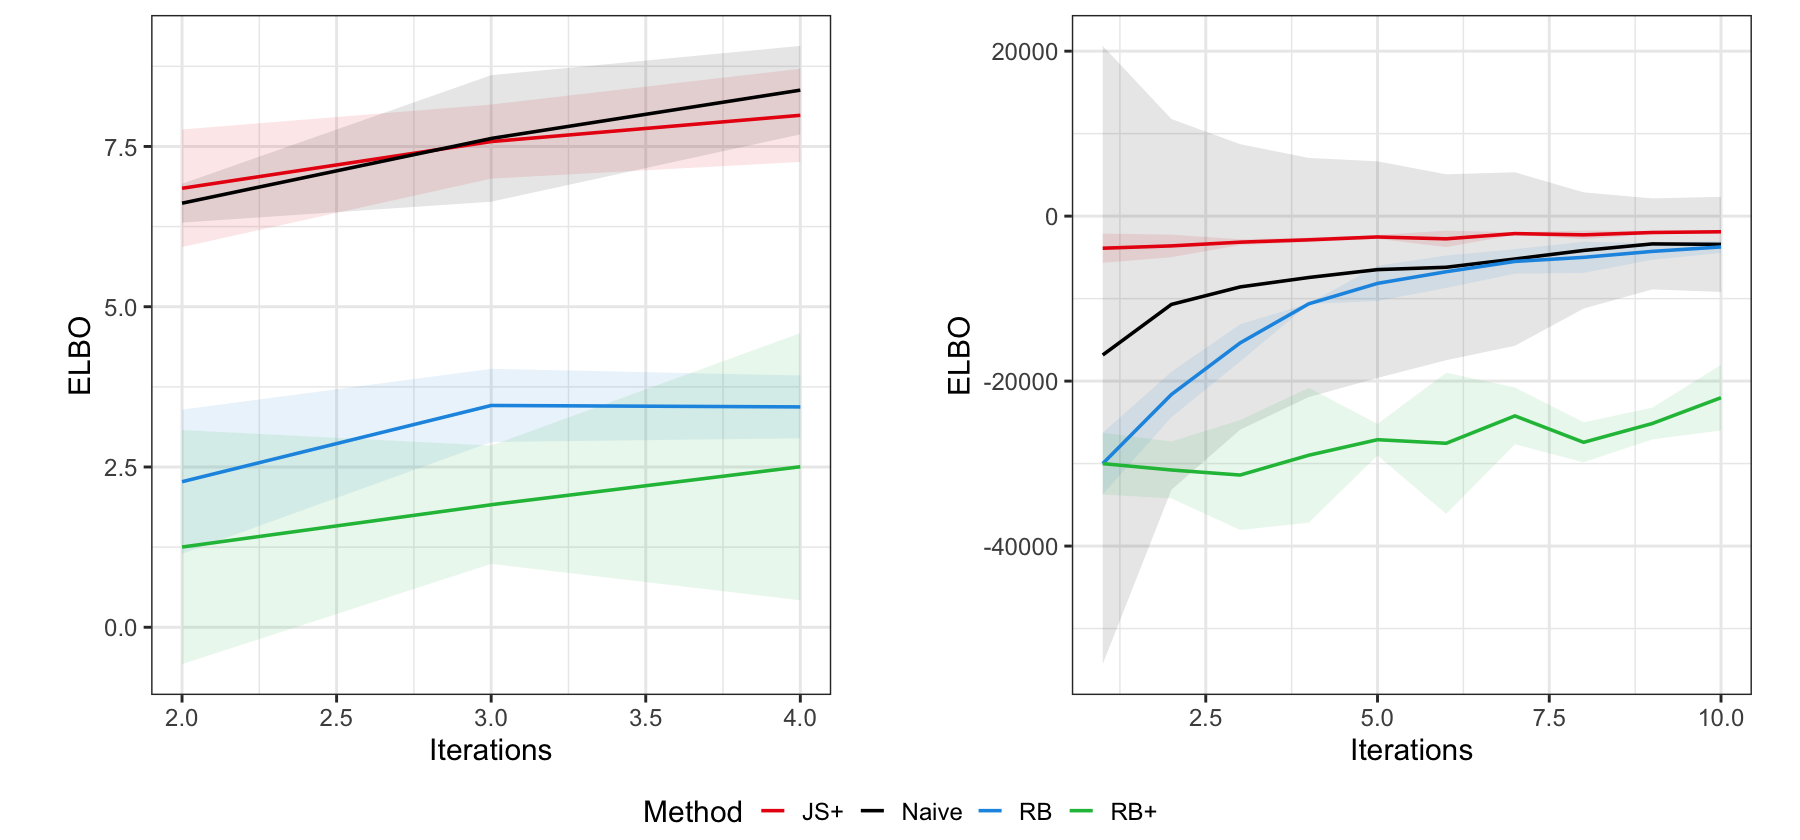

In [291]:
options(repr.plot.width = 15, repr.plot.height = 7)
ggarrange(p1, p2, nrow = 1, common.legend = TRUE, legend = "bottom")

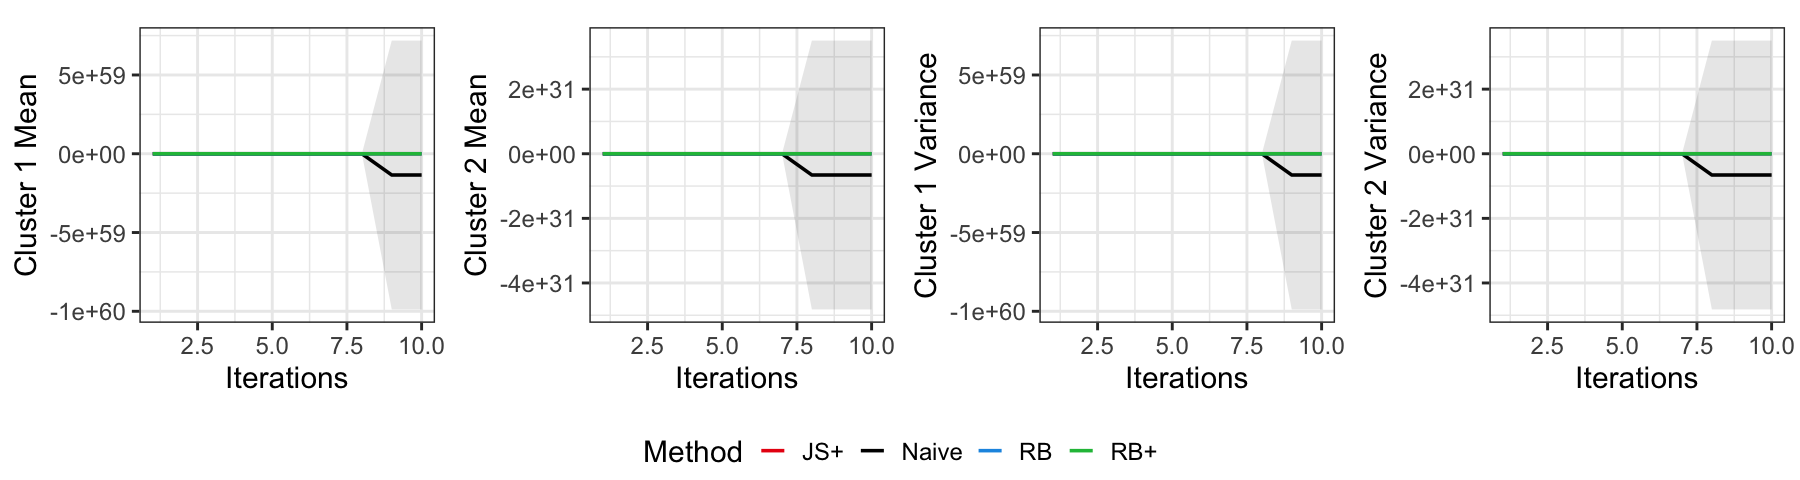

In [292]:
options(repr.plot.width = 15, repr.plot.height = 4)
ggarrange(p3, p4, p5, p6, nrow = 1, common.legend = TRUE, legend="bottom")